<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# VGG16 Transfer Learning — O vs R Image Classification

**Short description:**  
This notebook downloads an O-vs-R image dataset, builds transfer-learning pipelines using VGG16 (feature-extraction and fine-tuning), trains models, evaluates them on a test set and visualizes results (loss/accuracy curves and classification reports). The notebook demonstrates data augmentation, checkpointing, learning-rate scheduling and model inference.

**Context:**

*Transfer learning* uses the concept of keeping the early layers of a pre-trained network, and re-training the later layers on a specific dataset. You can leverage some state of that network on a related task.

A typical transfer learning workflow in Keras looks something like this:

1.  Initialize base model, and load pre-trained weights (e.g. ImageNet)
2.  "Freeze" layers in the base model by setting `training = False`
3.  Define a new model that goes on top of the output of the base model's layers.
4.  Train resulting model on your data set.

**Dataset:**

[Waste Classification Dataset](https://www.kaggle.com/datasets/techsash/waste-classification-data?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01).



**Objectives**
- Download and extract the dataset (zip) programmatically.
- Create ImageDataGenerators for training, validation and testing with augmentation and rescaling.
- Build a feature-extraction model with VGG16 base (pretrained on ImageNet) and dense classifier head.
- Train the feature-extraction model with callbacks (EarlyStopping, ModelCheckpoint, LearningRateScheduler).
- Fine-tune the last VGG block and retrain (partial unfreezing).
- Evaluate both models on test images, present classification reports and display example predictions.

**Notice about documentation:**  
The original notebook submission (course assignment) was kept intact. I have **only modified documentation (comments, headings, markdown)** and made **minimal, necessary corrections** to ensure the notebook runs without errors. All rights related to the lab/workshop design and original exercise belong exclusively to **IBM Corporation**. This notebook includes additional documentation for clarity, but the intellectual property of the original exercise is retained by IBM.

---

## Table of contents

1. Dependencies & execution instructions  
2. Download & extract dataset (zip)  
3. ImageDataGenerators and preview augmented images  
4. Build VGG16 feature-extraction model & classifier head  
5. Train feature-extraction model (callbacks and scheduler)  
6. Plot training history (loss & accuracy)  
7. Fine-tune last VGG block and retrain  
8. Load saved models and evaluate on test images  
9. Display classification reports and example predictions  
10. Notes & reproducibility


## 1) Dependencies & execution instructions

This section installs and imports required Python packages.  

**Recommended local execution steps:**

1. Create and activate a Python virtual environment:
   - `python -m venv venv`
   - `source venv/bin/activate` (macOS / Linux) or `venv\Scripts\activate` (Windows)
2. Install dependencies:
   - `pip install -r requirements.txt`
3. Launch Jupyter Notebook:
   - `jupyter notebook`
4. Open this notebook and run cells top-to-bottom.

**Note:** Training uses pretrained VGG16 and can be slow on CPU — GPU is recommended.

In [1]:
import numpy as np
import os
import glob
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn import metrics
import warnings
import requests
import zipfile
from tqdm import tqdm
from pathlib import Path
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

c:\Users\aleje\OneDrive - Universidad EAFIT\Escritorio\Alejandro\Academia\Portfolio\IBM AI Engineering Professional Certificate\4. DL with Keras and TF\Waste Product Classification\venv\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## 2) Download & extract dataset

Download the dataset ZIP file from the provided URL, extract files while showing progress, and remove the ZIP after extraction to save space. This will create a `o-vs-r-split` directory in your environment.


In [2]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip"
file_name = "o-vs-r-split-reduced-1200.zip"

print("Downloading file")
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)


def extract_file_with_progress(file_name):
    print("Extracting file with progress")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        members = zip_ref.infolist() 
        with tqdm(total=len(members), unit='file') as progress_bar:
            for member in members:
                zip_ref.extract(member)
                progress_bar.update(1)
    print("Finished extracting file")


extract_file_with_progress(file_name)

print("Finished extracting file")
os.remove(file_name)

Extracting file with progress


100%|██████████| 1207/1207 [00:02<00:00, 543.34file/s]

Finished extracting file
Finished extracting file


## 3) ImageDataGenerators and augmentation preview

Create `ImageDataGenerator` instances for training (with augmentation and validation split), validation and testing (rescale only). Instantiate `flow_from_directory` generators and preview a few augmented images created from a single sample.

In [3]:
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path = 'o-vs-r-split/train/'
path_test = 'o-vs-r-split/test/'
input_shape = (img_rows, img_cols, 3)
labels = ['O', 'R']
seed = 42

Image data generators create batches of tensor image data with real-time data augmentation. The generators loop over the data in batches and are useful in feeding data to the training process. 



In [4]:
# Create ImageDataGenerators for training and validation and testing
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [5]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)

Found 800 images belonging to 2 classes.


In [6]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

Found 200 images belonging to 2 classes.


In [7]:
test_generator = test_datagen.flow_from_directory(
    directory = path_test,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

Found 0 images belonging to 2 classes.


Labels: [np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O'), np.str_('O')]


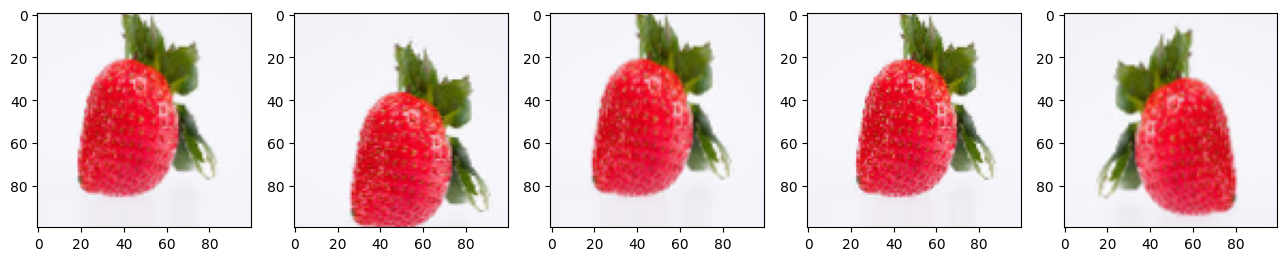

In [8]:
IMG_DIM = (100, 100)

train_files = glob.glob('./o-vs-r-split/train/O/*')
train_files = train_files[:20]
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [Path(fn).parent.name for fn in train_files]

img_id = 0
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]


## 4) Build VGG16 feature-extraction model & classifier head

Load pretrained VGG16 (exclude top), flatten its output, freeze base layers, and add a classifier head with Dense/Dropout layers and a sigmoid output for binary classification.

Pre-trained models are saved networks that have previously been trained on some large datasets. They are typically used for large-scale image-classification task. They can be used as they are or could be customized to a given task using transfer learning. These pre-trained models form the basis of transfer learning.


In [9]:
input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


The output of a vgg model is flattened and assigned to the model `output`. Then, the Model object `basemodel` is used to group the layers into an object for training and inference.
With the following inputs and outputs:

inputs: `vgg.input`

outputs: `tf.keras.layers.Flatten()(output)`


In [10]:
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

Freeze the basemodel.


In [11]:
for layer in basemodel.layers: 
    layer.trainable = False

* A new model on top is created. 
* A Dropout layer for regularization is added (only these layers will change) 
* For the lower layers `training=False` is set when calling the base model.


In [12]:
input_shape = basemodel.output_shape[1]

model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 8192)           │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,172,673 (73.14 MB)

 Trainable params: 4,457,985 (17.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 5) Train feature-extraction model

Compile model with `RMSprop optimizer` and `binary crossentropy`. Define callbacks: `EarlyStopping`, `ModelCheckpoint` and a `LearningRateScheduler` (exponential decay). Train for specified epochs and small `steps_per_epoch` for demonstration.

In [ ]:
for layer in basemodel.layers: 
    layer.trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

Early stopping is used to avoid over-training the model.


In [15]:
checkpoint_path='O_R_tlearn_vgg16.keras'

# define step decay function
class LossHistory_(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(epoch))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss', 
                    patience = 4, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

In [16]:
extract_feat_model = model.fit(train_generator, 
                               steps_per_epoch=5, 
                               epochs=10,
                               callbacks = callbacks_list_,   
                               validation_data=val_generator, 
                               validation_steps=val_generator.samples // batch_size, 
                               verbose=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5319 - loss: 0.7548lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 9s/step - accuracy: 0.5500 - loss: 0.7281 - val_accuracy: 0.7344 - val_loss: 0.5774 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6576 - loss: 0.6242lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 9s/step - accuracy: 0.6812 - loss: 0.6317 - val_accuracy: 0.8281 - val_loss: 0.4938 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8005 - loss: 0.5040lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 9s/step - accuracy: 0.7500 - loss: 0.5535 - val_accuracy: 0.8073 - val_loss: 0.4616 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7620 - loss: 0.5051lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 10s/step - accuracy: 0.7500 - loss: 0.5149 - val_accuracy: 0.8333 - val_loss: 0.4286 - learning_rate: 7.4082e-05
Epoch 5/10


## 6) Plot training history

Plot training & validation loss and accuracy curves from the training history object to inspect learning behavior.

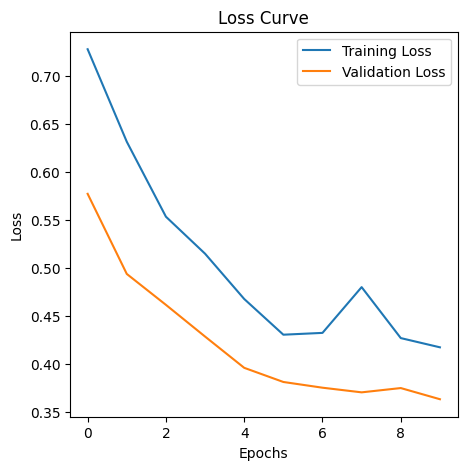

In [ ]:
history = extract_feat_model

# Plot loss curves for training and validation sets
plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

**NOTE:** As training is a stochastic process, the loss and accuracy graphs may differ across runs. As long as the general trend shows decreasing loss and increasing accuracy, the model is performing as expected.

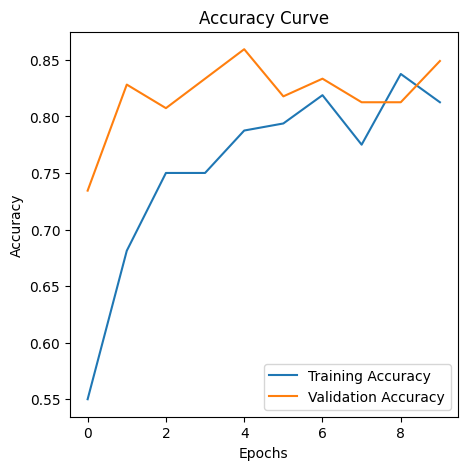

In [ ]:
history = extract_feat_model

# Plot accuracy curves for training and validation sets
plt.figure(figsize=(5,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7) Fine-tuning

Partially unfreeze the last convolutional block (e.g. `block5_conv3`) of VGG16, recompile and fine-tune the combined model with the same callbacks and schedule. Save the best model.

**Unfreeze** one layer from the base model and train the model again.


In [19]:
input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

for layer in basemodel.layers: 
    layer.trainable = False

display([layer.name for layer in basemodel.layers])

set_trainable = False

for layer in basemodel.layers:
    if layer.name in ['block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in basemodel.layers:
    print(f"{layer.name}: {layer.trainable}")

['input_layer_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten_1']

input_layer_2: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: False
block5_conv3: True
block5_pool: True
flatten_1: True


In [20]:
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

checkpoint_path='O_R_tlearn_fine_tune_vgg16.keras'

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss', 
                    patience = 4, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

fine_tune_model = model.fit(train_generator, 
                    steps_per_epoch=5, 
                    epochs=10,
                    callbacks = callbacks_list_,   
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples // batch_size, 
                    verbose=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4896 - loss: 0.7829lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 10s/step - accuracy: 0.5312 - loss: 0.7290 - val_accuracy: 0.7969 - val_loss: 0.5194 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7179 - loss: 0.5479lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 10s/step - accuracy: 0.7250 - loss: 0.5619 - val_accuracy: 0.8021 - val_loss: 0.4493 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8134 - loss: 0.5010lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 45s 10s/step - accuracy: 0.7937 - loss: 0.4887 - val_accuracy: 0.8125 - val_loss: 0.4029 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8614 - loss: 0.4081lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 47s 11s/step - accuracy: 0.8250 - loss: 0.4391 - val_accuracy: 0.8802 - val_loss: 0.3299 - learning_rate: 7.4082e-05
Epoch 5/

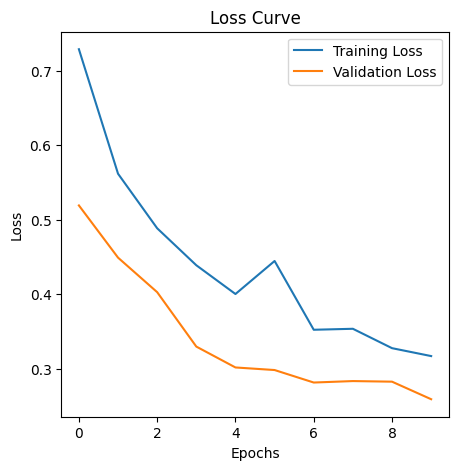

In [ ]:
history = fine_tune_model

## Plot loss curves for training and validation sets (fine tune model)
plt.figure(figsize=(5,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

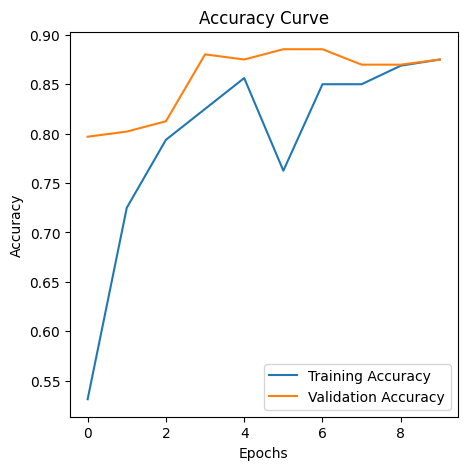

In [ ]:
history = fine_tune_model

# Plot accuracy curves for training and validation sets  (fine tune model)
plt.figure(figsize=(5,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 8) Load saved models and evaluate on test images

Load the saved models from checkpoints, prepare test images, scale them, run predictions for both models and convert predictions to class labels for reporting.

In [27]:
# Load saved models
extract_feat_model = tf.keras.models.load_model('O_R_tlearn_vgg16.keras')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_fine_tune_vgg16.keras')

IMG_DIM = (150, 150)

# Load test images
test_files_O = glob.glob('./o-vs-r-split/test/O/*')
test_files_R = glob.glob('./o-vs-r-split/test/R/*')
test_files = test_files_O[:50] + test_files_R[:50]

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [Path(fn).parent.name for fn in test_files]

# Standardize
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

# Make predictions for both models
predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

# Convert predictions to class labels
predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)


In [28]:
# Print classification report for both models
print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))

Extract Features Model
              precision    recall  f1-score   support

           O       0.70      0.90      0.79        50
           R       0.86      0.62      0.72        50

    accuracy                           0.76       100
   macro avg       0.78      0.76      0.76       100
weighted avg       0.78      0.76      0.76       100

Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.80      0.88      0.84        50
           R       0.87      0.78      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100



## 9) Classification reports & sample predictions

Print classification reports (precision/recall/F1) for both models and display example test images with actual and predicted labels as titles.


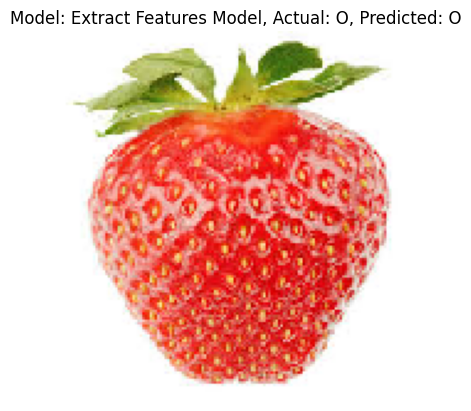

In [ ]:
# Plot one of the images with actual label and predicted label as title
def plot_image_with_title(image, model_name, actual_label, predicted_label):
    plt.imshow(image)
    plt.title(f"Model: {model_name}, Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Specify index of image to plot
index_to_plot = 0
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot], 
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )

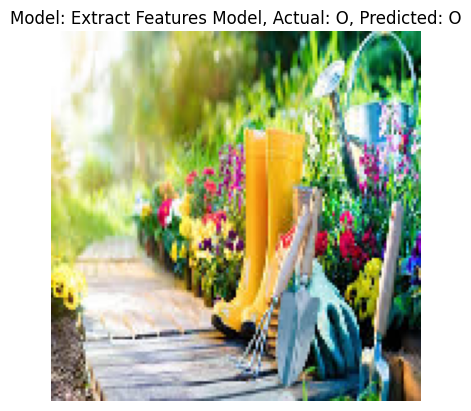

In [ ]:
index_to_plot = 1
plot_image_with_title(
    image = test_imgs[index_to_plot].astype('uint8'),
    model_name = 'Extract Features Model',
    actual_label = test_labels[index_to_plot],
    predicted_label = predictions_extract_feat_model[index_to_plot]
)

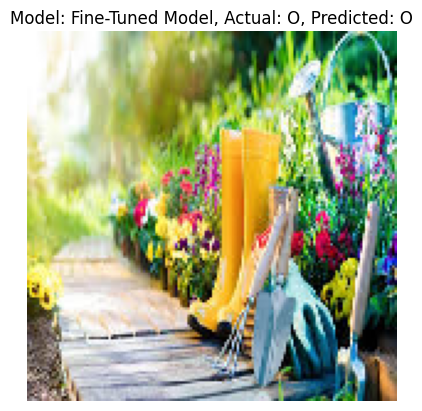

In [ ]:
index_to_plot = 1
plot_image_with_title(
    image = test_imgs[index_to_plot].astype('uint8'),
    model_name = 'Fine-Tuned Model',
    actual_label = test_labels[index_to_plot],
    predicted_label = predictions_fine_tune_model[index_to_plot]
)

## 10) Notes & reproducibility

- The notebook downloads ~ZIP data — ensure network access or replace with a local dataset.    
- Adjust `steps_per_epoch`, `epochs`, and `batch_size` to fit your computational resources.

Copyright © IBM Corporation. All rights reserved.
